# SKY SUBTRACTIONS

1- GETTING BIAS, DARK CURRENT AND FLAT OUT OF THE SCIENTIFIC IMAGE.MULTIPLY BY THE GAIN FOR PHYSICAL ELECTRONS THEN USE THE CALIBRATION CONSTANT FOR PHYSICAL UNITS (erg/s/cm^2).

2- SUBTRACTING THE ATMOSPHERIC SKY OUT OF THE IMAGE BACKGROUND.


In [7]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sep
from photutils.aperture import CircularAperture
import re

# A&A specific settings
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"], # A&A uses a Times-based font
    "axes.labelsize": 13,    # Standard size for A&A captions/labels
    "font.size": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "text.latex.preamble": r"\usepackage{txfonts}" # This matches the A&A math style
})

path_bias = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/BIAS"
path_galaxy = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/LIGHT"
path_dark = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/DARK"
path_flat = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/FLAT"

In [8]:
image_path = "/2025-09-29_18-40-52_sci_NGC6946_R_exp300.00_0002.fits"  # Literally, don't change anything else. The next few lines solved the issue.
match = re.search(r'_([A-Z])_exp(\d+)\.00_00(\d+)\.fits$', image_path)
let = match.group(1)
exp = match.group(2)
num = match.group(3)
flat_master = f"/master_flat_{let}.fits"

with fits.open(path_galaxy + image_path) as hdu_galaxy:
  image_data_galaxy = hdu_galaxy[0].data
with fits.open(path_bias +"/master_bias.fits") as hdu_bias:
  master_bias = hdu_bias[0].data
with fits.open(path_dark +"/master_dark_300.fits") as hdu_dark:
  master_dark = hdu_dark[0].data
with fits.open(path_flat + flat_master) as hdu_flat:
  master_flat = hdu_flat[0].data

t_exp_galaxy = int(exp)
t_exp_dark = 300
g = 0.25 # electron/ADU  -----> This is the gain: transformation factor between electrons and ADU units.(It is giving from the telescope guide book)
# Step 1: Clean the image
cleaned_image = ((image_data_galaxy - master_bias - (master_dark*t_exp_galaxy/t_exp_dark))/ master_flat)*g # UNITS NOW ARE IN   e/pixel
calibration_constant = {
    "G": {
        "00": 5.30e-17,
        "01": 5.38e-17,
        "02": 5.33e-17
    },
    "R": {
        "00": 5.50e-17,
        "01": 5.49e-17,
        "02": 5.42e-17,
        "03": 5.48e-17
    },
    "I": {
        "01": 4.59e-17,
        "02": 4.64e-17
    }
}
cal_const = calibration_constant[let][num]
# Step 2: Convert to physical flux
physical_image = cleaned_image * cal_const /1e-17  # Units are in erg/s/cm^2  / e-17
np.mean(cleaned_image * cal_const)

np.float64(4.8822135223367165e-14)

### Summary: we are trying to remove the noises from the background masking the galaxy and stars.
Subtracting the sky_level would shift the values to zero. It would ignore the very bright objects which would eliminate high variations in the image.

bkg will be subtracted after masking valuable objects(stars and galaxy), measure a spatially varying background on the image.

The resultant image is for clear details about bright sources in the sky.

## The stars are reference objects in Galaxy images, so we need to mask them too.
* Stars must be extracted in sep.extract as they would affect the result of the background value. The background light is very low compared to the stars and the galaxy.

The number of detected stars = 3361


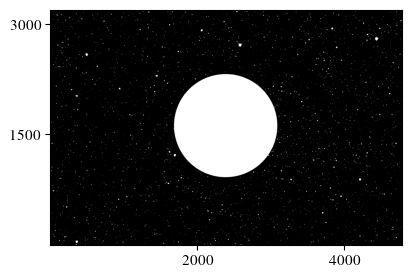

In [9]:
sky_level = np.median(physical_image)
physical_subtracted = physical_image - sky_level  # (Eliminate bright objects that shifts the mean)

thresh = 2.9    #################    Change to extract as much as you can objects. We need to save as much as we can from the image elements.
bkg = sep.Background(physical_subtracted)    # measure a spatially varying background on the image
objects, segmap = sep.extract(physical_subtracted, thresh = thresh , err= bkg.globalrms, segmentation_map=True) # Object flux indecies , segmap
print(f"The number of detected stars = {len(objects)}")

# segmap[1000:2000,2100:2900] = 100  # We will use the circular masking (aperture), this line would give rectangular
position_x , position_y = 2382  ,1622
position = (position_x,position_y)
aperture = CircularAperture(position, r=700)
mask_galaxy = aperture.to_mask(method='exact').to_image(physical_subtracted.shape).astype(bool)
segmap |= mask_galaxy # Replaces everything detected in segmap in the aperture range by the aperture itself. See the yellow circle in the image.

plt.figure(figsize= (10,5))
plt.subplot(1,2,1)
plt.imshow(segmap, origin='lower', clim=(0,1), cmap = 'grey')
plt.xticks([2000,4000])
plt.yticks([1500,3000])
# plt.title('Detected objects')

bkg_masked = sep.Background( physical_subtracted , mask= segmap , fw = 20 , fh = 20 )
physical_skysub = physical_subtracted - bkg_masked

# plt.subplot(1,2,2)
# plt.imshow(physical_skysub, cmap= 'grey', origin='lower', clim=(-10,100))
# aperture.plot(color='white', lw=1.5, alpha=0.5)
# # plt.colorbar()
# plt.title(f'Removed bkg (thresh = {thresh}) filter_{let}_{num}')
# plt.tight_layout()
# plt.show()

In [ ]:
# hdu_image = fits.PrimaryHDU(physical_skysub, header=hdu_galaxy[0].header)
# #HDUList object(Make a list file)
# hdu_list_image = fits.HDUList([hdu_image])
# #FITS file
# hdu_list_image.writeto(path_galaxy + f"/sky_subtracted_{let}_{exp}_{num}.fits", overwrite=True)